<a href="https://colab.research.google.com/github/project-ida/two-state-quantum-systems/blob/master/02-perturbing-a-two-state-system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 - Perturbing a two state system

In this tutorial we are going to explore what happens when we connect a two state system to the "outside world". Or, put another way, what happens when we perturb a two state system? We'll look at two cases:
1. Static perturbations
2. Small, time-dependent perturbations

A reminder that in QuTiP $\hbar=1$ and so frequency and energy are completely interchangeable.

First, let's load the libraries and some custom code to make plotting easier later.

In [1]:
# Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qutip import *
import warnings
warnings.filterwarnings('ignore')

## note, if you start getting errors when using pandas with complex numbers then update Pandas
## - there was a bug that's been recently fixed https://github.com/pandas-dev/pandas/issues/27484

# Function created in 01 tutorial to make plotting of states calculated from `sesolve` easier
def states_to_df(states,times):
    psi_plus = np.zeros(len(times),dtype="complex128")  # To store the amplitude of the |+> state
    psi_minus = np.zeros(len(times),dtype="complex128") # To store the amplitude of the |-> state

    for i, state in enumerate(states):
        psi_plus[i] = state[0][0][0]
        psi_minus[i] = state[1][0][0]

    return pd.DataFrame(data={"+":psi_plus, "-":psi_minus}, index=times)

## 2.1 Static perturbation

Last time we looked at an isolated two state system whose base states **|+>** and **|->** were represented as

$$
|+> = \begin{bmatrix}
 1   \\
 0   \\
 \end{bmatrix}, 
|-> = \begin{bmatrix}
 0   \\
 1   \\
\end{bmatrix}
$$

and whose energies $E_0$ were identical. When we considered that coupling between the states could occur (with strength $A$), the hamiltonian for the system could then be represented as

$$
H = \begin{bmatrix}
 E_0  &  -A  \\
 -A  &  E_0  \\
\end{bmatrix} = E_0 I - A \sigma_x
$$


where $I$ is the identity matrix and $ \sigma_x$ one of the Pauli matrices.

In this tutorial, we will introduce a perturbation in energy, $\delta$, that differentiates between the two states. Physically, one can think of this as e.g. applying an electric field to a molecule with a permanent dipole moment. We can then represent the Hamiltonian as:

$$
H = \begin{bmatrix}
 E_0 + \delta  &  -A  \\
 -A  &  E_0 - \delta  \\
\end{bmatrix} = E_0 I - A \sigma_x + \delta\sigma_z
$$

In effect this perturbation increase the energy of the |+> state and lowers the energy of the |-> state.

Let's explore how this changes the previous case of an isolated two state system.

As before, we represent the base states in QuTip as:

In [2]:
plus = basis(2, 0)
minus = basis(2, 1)

We'll use the same parameters as in the previous tutorial, i.e. $E_0=1$, $A=0.1$, throughout this tutorial.

We'll begin by taking the perturbation to be $\delta = 2A$ and initialising the system in the |+> state.

In [3]:
E0 = 1.0
delta = 0.2
A = 0.1

H = E0*qeye(2) - A*sigmax() + delta*sigmaz()

times = np.linspace(0.0, 70.0, 1000) 

result = sesolve(H, plus, times)
df =  states_to_df(result.states, times)


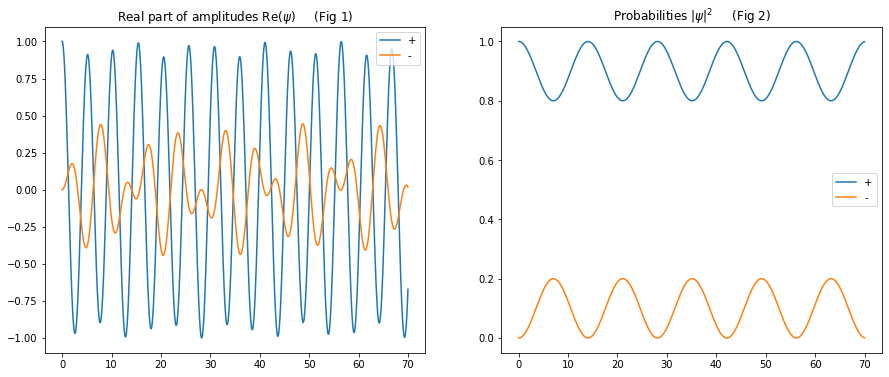

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
df.plot(title="Real part of amplitudes Re($\psi$)     (Fig 1)", ax=axes[0]);
(df.abs()**2).plot(title="Probabilities $|\psi|^2$     (Fig 2)", ax=axes[1]);

Just as in the previous tutorial (see Figs 3 & 4), we see Rabi oscillations in the probability because |+> and |-> are not stationary states. The behaviour is again like $\cos^2(\Omega t/2)$, but somewhat modified by the perturbation.

1. The period of oscillations has gone from 31 to about 14 (recall, we have kept A the same)
2. Instead of a complete oscillation from 0 to 1 of both states, we see that we are more likely to find the state as |+>. 

We can understand 2 by recalling that the perturbation creates an energy difference between the |+> and |->. This gives rise to a frequency difference much like what we'd have in the classical coupled pendulum problem if the lengths of the pendulums were different. In that case the coupling is much less effective and most of the energy stays in pendulums of the same length as can be seen in this [simulation video](https://www.youtube.com/watch?v=Z5rKTagEsro)

To understand 1 we recall that the Rabi frequency arises as the beating between the different frequencies of the stationary states, i.e. $\Omega = \Delta E$. We therefore need to calculate the energy of the stationary states, i.e. we need to calculate the eigenvalues of the Hamiltonian.

Let's do this for a number of different perturbation strengths:

In [5]:
n_deltas = 50
smallest_delta = 0.01
deltas = smallest_delta*np.array(range(0,n_deltas))
upper = np.zeros(n_deltas)
lower = np.zeros(n_deltas)

for i, d in enumerate(deltas):
    H_delta = E0*qeye(2) - A*sigmax() + d*sigmaz()
    E = H_delta.eigenenergies()
    upper[i] = E[1]
    lower[i] = E[0]
energies = pd.DataFrame(data={"upper":upper, "lower":lower, "$\delta$/A":deltas/A})

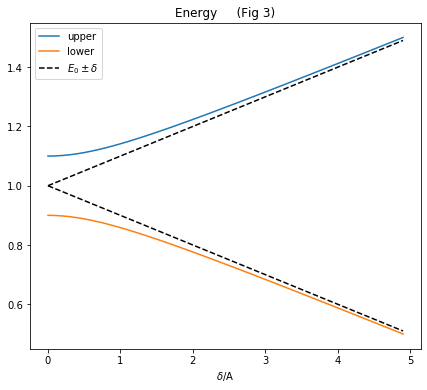

In [6]:
energies.plot(x="$\delta$/A", title="Energy     (Fig 3)", figsize=(7,6));
plt.plot((deltas/A),(E0+deltas),'k--')
plt.plot((deltas/A),(E0-deltas),'k--',label="$E_0 \pm \delta$");
plt.legend();

Let's see if Fig 3 makes sense. 

In the extreme, as $\delta\rightarrow \infty$, the energy asymptotically approaches to $E_0 \pm \delta$ - this is consistent with the coupling becoming less and less important. At the other extreme, $\delta \rightarrow 0$ and we recover the result from the last tutorial, i.e. $E_0 \pm A$.

The form of the energy curve is actually a relatively simple formula $E_0 \pm \sqrt{A^2 + \delta^2}$ (we won't derive this result here, but instead link you to a [lecture from Richard Feynman](https://www.feynmanlectures.caltech.edu/III_09.html#Ch9-S2)). From this we can now calculate $\Omega = \Delta E = 2\sqrt{A^2 + \delta^2} = 2\sqrt{0.1^2 + 0.2^2} = 0.44$ giving a Rabi oscillation period of $2\pi/\Omega = 14$ that we saw graphically in Fig 2.

For more of a deep dive into the dependence of energy on the various parts the Hamiltonian, consult the intimately connected topic of [avoided crossings](https://en.wikipedia.org/wiki/Avoided_crossing).



We see that the energy has changed a lot due to the perturbation, what about the stationary states themselves?

In [7]:
H.eigenstates()

(array([0.7763932, 1.2236068]),
 array([Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[-0.22975292]
  [-0.97324899]],
        Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[-0.97324899]
  [ 0.22975292]]], dtype=object))

Compare these to the stationary states we found in the previous tutorial -  let's rewrite them here for convenience:

$\frac{|+> + \,\  |->}{\sqrt{2}}$ - in phase (a.k.a symmetric) - lower energy state

$\frac{|+> - \,\  |->}{\sqrt{2}}$ - out of phase (a.k.a anti-symmetric) - higher energy state

In [8]:
in_phase = (plus + minus).unit()
out_phase = (plus - minus).unit()

We see that the lower energy state is symmetric as in the previous tutorial (i.e both parts of the state have the same sign) and we have less of the energetically expensive |+> state and more of the |->.

Other than the symmetry, there isn't much similarity with the stationary states from the last tutorial. This makes sense when we recall that $\delta=2A$ - it's a strong perturbation so it changes the system a lot.

There is some really interesting physics that happens when we don't perturb the system too much, i.e $\delta/A \ll 1$, so we are going to explore this regime next in the context of time dependent perturbation.

## 2.2 Time dependent perturbation

We are now going to consider a time dependent perturbation of the form $\delta\sigma_z\cos(\omega t)$ with $\delta/A = 0.01 \ll 1$. 

With QuTiP, we can add [time dependence in several ways](http://qutip.org/docs/latest/guide/dynamics/dynamics-time.html). We will use the [string based method](http://qutip.org/docs/latest/guide/dynamics/dynamics-time.html#string-format-method) because the code compiles into C and so it's faster (this means you need to have Cython installed on your computer).

It works by specifying the Hamiltonian as $H=H_0 + H_1C(t)$, where $C$ should be a function (or combinations) from the list below

```
'abs', 'acos', 'acosh', 'arg', 'asin', 'asinh', 'atan', 'atanh', 'conj',
 'cos', 'cosh','exp', 'erf', 'zerf', 'imag', 'log', 'log10', 'norm', 'pi',
 'proj', 'real', 'sin', 'sinh', 'sqrt', 'tan', 'tanh'
```

In QuTip, we put this together as the list `H = [H0, [H1,C]]` and feed it into `sesolve` just like we did before.

The question now is, what should we choose the frequency $\omega$ to be?

### Resonance

Because we are only perturbing the system slightly, we can expect that the energy difference between the two unperturbed stationary states (i.e. $2A$) should still be something of interest. It is natural therefore to begin by setting $\omega = \omega_0 \equiv 2A$. 

Intuitively we do expect some kind of resonance phenomenon because we are matching the driving frequency to the "natural" frequency of the two state system - but how will this resonance manifest?

Let's start things off in a stationary state of the unperturbed system, specifically, |+> + |->. Does the system stay close to this state as we might expect, given the smallness of the perturbation.

Let's see.

In [9]:
E0 = 1.0
delta = 0.001
A = 0.1

H0 = E0*qeye(2) - A*sigmax() 

H1 =  delta*sigmaz()

H = [H0,[H1,'cos(w*t)']]

times = np.linspace(0.0, 15000.0, 1000) 

result = sesolve(H, in_phase, times, args={'w':2*A})
df_res =  states_to_df(result.states, times)


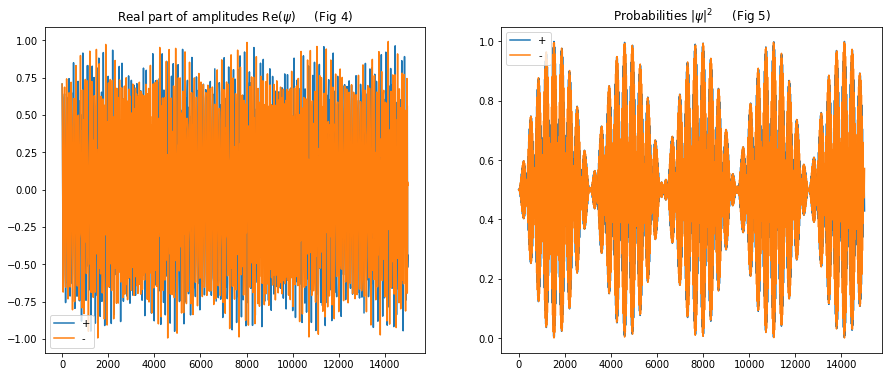

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
df_res.plot(title="Real part of amplitudes Re($\psi$)     (Fig 4)", ax=axes[0]);
(df_res.abs()**2).plot(title="Probabilities $|\psi|^2$     (Fig 5)", ax=axes[1]);

We can clearly see something interesting is happening. The probabilities are undergoing full oscillation from 1 to 0 and we can see a much longer oscillation timescale than before.

It is however, quite difficult to be more specific from this plot. That's because we are still using the |+> and |-> basis to describe the system. The best basis to work with is one in which the base states are exactly, or at least close to, the stationary states. In this case, that's $\frac{|+> + \,\  |->}{\sqrt{2}}$  and $\frac{|+> - \,\  |->}{\sqrt{2}}$.

Changing the basis of a state is actually very easy in QuTiP, we just take any state `s` and apply the [transform](http://qutip.org/docs/latest/apidoc/classes.html?highlight=transform#qutip.Qobj.transform) method to it `s.transform(new_base_states)`.

Each state vector needs to be transformed separately, so let's create a function to do this for the many states that comes from solving the Schrödinger equation.

In [11]:
def change_basis_to_df(states, times, new_basis, new_basis_labels):
    psi_new_basis_0 = np.zeros(len(times),dtype="complex128")  # To store the amplitude of the new_basis_0 state
    psi_new_basis_1 = np.zeros(len(times),dtype="complex128") # To store the amplitude of the new_basis_1 state

    for i, state in enumerate(states):
        transformed_state = state.transform(new_basis)
        psi_new_basis_0[i] = transformed_state[0][0][0]
        psi_new_basis_1[i] = transformed_state[1][0][0]

    return pd.DataFrame(data={new_basis_labels[0]:psi_new_basis_0, new_basis_labels[1]:psi_new_basis_1}, index=times)

In [12]:
df_res_basis = change_basis_to_df(result.states, times, [in_phase,out_phase], ["|x> + |->", "|x> - |->"])

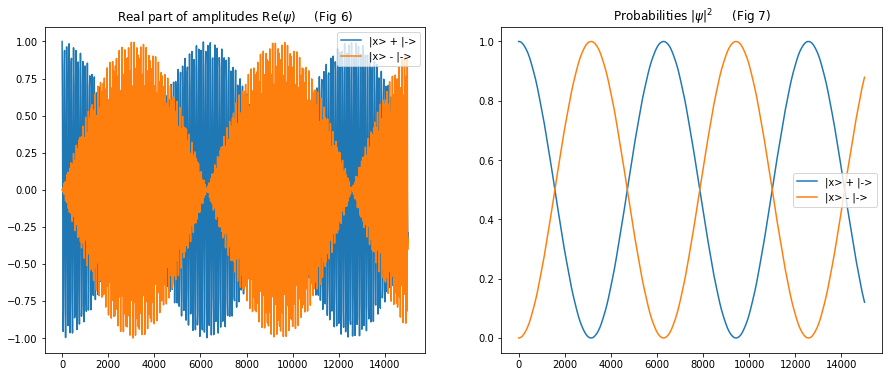

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
df_res_basis.plot(title="Real part of amplitudes Re($\psi$)     (Fig 6)", ax=axes[0]);
(df_res_basis.abs()**2).plot(title="Probabilities $|\psi|^2$     (Fig 7)", ax=axes[1]);

Now, we can see better.

Even though we only perturb the system slightly, i.e $\delta/A = 0.01$ is small, when we "resonantly" perturb the system we cause a significant change, i.e. we cause the the system to transition between higher an lower energy states - this is the essence of stimulated emission/absorption in atomic systems.

The oscillation of the probability is again referred to as Rabi oscillations (or sometimes called the [Rabi cycle](https://en.wikipedia.org/wiki/Rabi_cycle)). This time, however, the Rabi frequency is not determined by the beat frequency between the unperturbed stationary states but instead by the perturbation strength alone. 

Specifically, $\Omega = \delta$, giving a period of $2\pi/\Omega = 2\pi/0.001 \approx 6300$.

This result is not immediately intuitive (see [derivation](https://en.wikipedia.org/wiki/Rabi_problem#Semiclassical_approach)), so we will return to this at a later point and derive it using perturbation theory.

For now we will continue exploring. Now that we've seen the effect of resonance, it is natural to wonder how sensitive it is to changes in frequency.

### Off resonance

Let's start by changing the frequency so that $(\omega-\omega_0)/\omega_0 = 1\%$.

In [14]:
E0 = 1.0
delta = 0.001
A = 0.1

H0 = E0*qeye(2) - A*sigmax()

H1 =  delta*sigmaz()

H = [H0,[H1,'cos(w*t)']]

times = np.linspace(0.0, 15000.0, 1000) 

result = sesolve(H, in_phase, times, args={'w':(2*A)*1.01})
df_off_res =  states_to_df(result.states, times)


In [15]:
df_off_res_basis = change_basis_to_df(result.states, times, [in_phase,out_phase], ["|x> + |->", "|x> - |->"])

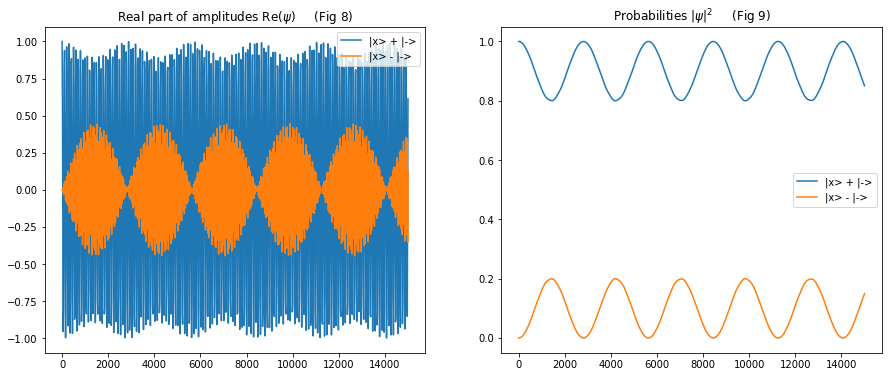

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
df_off_res_basis.plot(title="Real part of amplitudes Re($\psi$)     (Fig 8)", ax=axes[0]);
(df_off_res_basis.abs()**2).plot(title="Probabilities $|\psi|^2$     (Fig 9)", ax=axes[1]);

We can see that the resonance is exquisitely sensitive. When the frequency is just 1% off resonance, the amplitude of probability oscillation is reduced to 20% of it's previous value. The Rabi frequency has also changed. The modified value is often called the [generalised Rabi frequency](https://en.wikipedia.org/wiki/Rabi_frequency#Generalized_Rabi_frequency) and has the form $\bar\Omega = \sqrt{\Omega^2 + (\omega-\omega_0)^2} =  \sqrt{\delta^2 + (\omega-\omega_0)^2} = \sqrt{0.001^2 + 0.002^2} = 0.002$, giving the period $2\pi/\bar\Omega = 2\pi/0.002 \approx 3100$ that we can see in Fig 9.

## Next up...
So far, we've developed an intuition for a simple two state system and how it behaves in a presence of an external perturbation. We've uncovered the physical basis for stimulated emission and absorption in atomic systems. You might be wondering, what about spontaneous emission? We cannot describe it using this model 😞. We must go a level deeper and consider not only how the perturbation acts on the two state system, but how the two state system acts on the perturbation. Put another way, we need to consider the perturbation as a field that can itself be quantised 🤯.